In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 337.95it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 5257.60it/s]


absolute alignment indicates number: 123 label diff indicates number: 10007 confidence diff indicates number: 12 high distance number: 8025


In [2]:
from AlignVisAutoEncoder.autoencoder import Autoencoder

In [14]:
input_dim = 512
output_dim = 512
hidden_dims = [512, 512, 512]
autoencoder = Autoencoder(input_dim, output_dim, hidden_dims)


In [15]:
from AlignVisAutoEncoder.data import DataLoaderInit
data_loader = DataLoaderInit(ref_train_data, tar_train_data)
dataloader = data_loader.get_data_loader()

In [18]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
from pyemd import emd
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph

def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)
    # X, Y = X.detach().numpy(), Y.detach().numpy()
    # distance_matrix = cdist(X, Y)
    # first_histogram = np.ones(X.shape[0]) / X.shape[0]
    # second_histogram = np.ones(Y.shape[0]) / Y.shape[0]
    # return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

# Define hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 1e-5

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements

# Training loop
for epoch in range(num_epochs):
    for data_X, data_Y in dataloader: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        # Calculate the loss
        # recon_loss = criterion(recon_X, data_X)

        # topological_loss = earth_movers_distance(data_Y, transformed_Y)

        # loss = recon_loss + alpha * topological_loss
        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_X, recon_X)
        loss_f_decoder = frobenius_norm_loss(recon_X, data_Y) + topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        loss = loss_f_decoder + loss_f_encoder 

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},')


Epoch [1/10], Loss: 0.0102, Loss decoder: 0.0047,Loss encoder: 0.0055,
Epoch [2/10], Loss: 0.0101, Loss decoder: 0.0047,Loss encoder: 0.0054,
Epoch [3/10], Loss: 0.0097, Loss decoder: 0.0046,Loss encoder: 0.0051,
Epoch [4/10], Loss: 0.0097, Loss decoder: 0.0045,Loss encoder: 0.0052,
Epoch [5/10], Loss: 0.0095, Loss decoder: 0.0043,Loss encoder: 0.0052,
Epoch [6/10], Loss: 0.0095, Loss decoder: 0.0044,Loss encoder: 0.0051,
Epoch [7/10], Loss: 0.0094, Loss decoder: 0.0045,Loss encoder: 0.0049,
Epoch [8/10], Loss: 0.0091, Loss decoder: 0.0042,Loss encoder: 0.0049,
Epoch [9/10], Loss: 0.0096, Loss decoder: 0.0043,Loss encoder: 0.0053,
Epoch [10/10], Loss: 0.0094, Loss decoder: 0.0044,Loss encoder: 0.0050,


In [9]:
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)

In [10]:
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8342.96it/s]


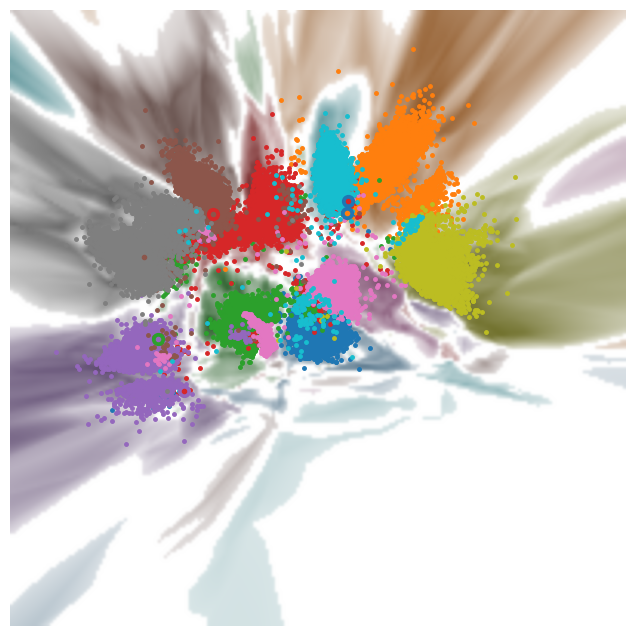

In [52]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 4219.62it/s]


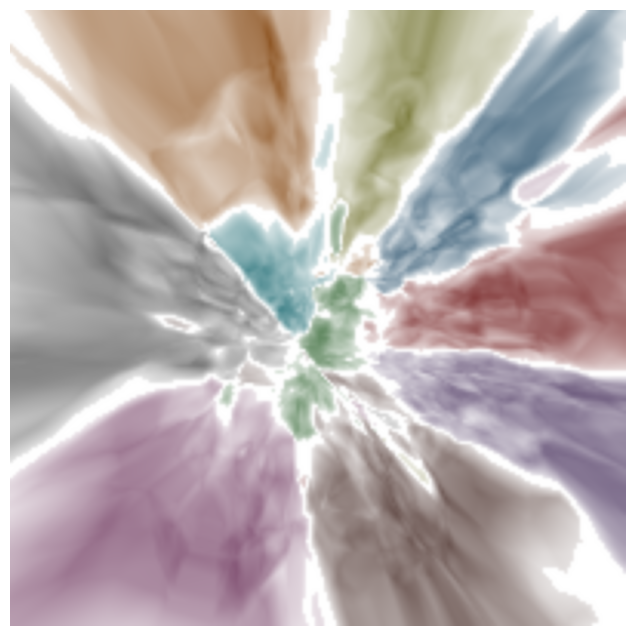

In [21]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, autoencoder,I,I, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 2768.65it/s]


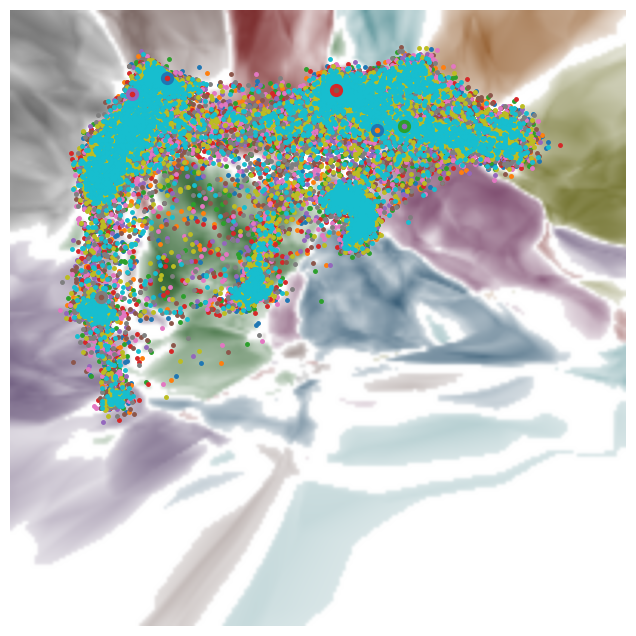

In [66]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8696.46it/s]


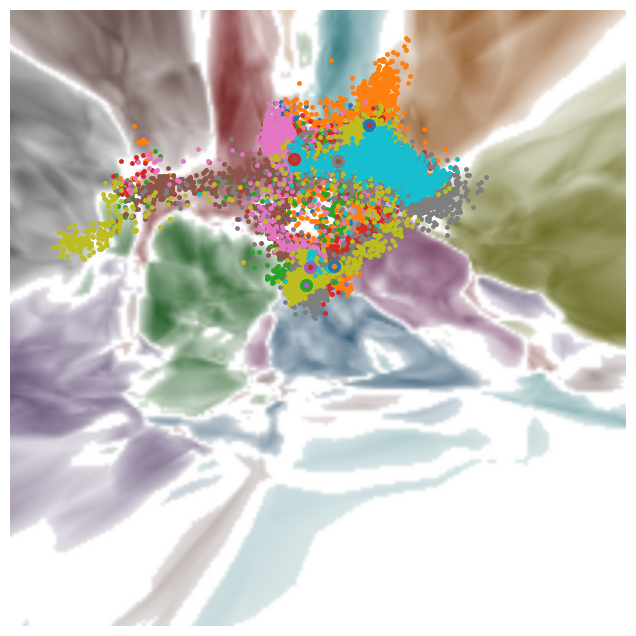

In [48]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))